# **Import Libraries**

In [2]:
# Install missing packages
#%pip install pandas seaborn statsmodels scikit-learn
#%pip install xgboost
#%pip install numpy


# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Stats & Time Series (optional for decomposition/stationarity testing)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Scikit-learn: Models, Metrics, Scaling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV

# **Import Data**

In [3]:
# setting the file path - locally.
file_path = './data_store_sales/'
# Load the merged files into pandas DataFrames
df_train= pd.read_csv(file_path+'feature_eng_upto_2014.csv')

In [20]:
df_train.head(10)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,is_holiday,is_event,dayofweek,...,promo_last_week,oil_price_lag_3,oil_price_change,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7
0,24,96995,2013-01-02,0.0,0,0,93.140000,0,0,2,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-01-03,0.0,0,0,92.970000,0,0,3,...,NaN,NaN,-0.001825,0,0,0.0,NaN,NaN,NaN,NaN
2,24,96995,2013-01-04,0.0,0,0,93.120000,0,0,4,...,NaN,NaN,0.001613,0,0,0.0,NaN,NaN,NaN,NaN
3,24,96995,2013-01-05,0.0,0,0,93.146667,0,0,5,...,NaN,93.140000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
4,24,96995,2013-01-06,0.0,0,0,93.173333,0,0,6,...,NaN,92.970000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
5,24,96995,2013-01-07,0.0,0,0,93.200000,0,0,0,...,NaN,93.120000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
6,24,96995,2013-01-08,0.0,0,0,93.210000,0,0,1,...,NaN,93.146667,0.000107,0,0,0.0,NaN,NaN,NaN,NaN
7,24,96995,2013-01-09,2.0,0,0,93.080000,0,0,2,...,0.0,93.173333,-0.001395,0,0,0.0,0.0,NaN,NaN,0.0
8,24,96995,2013-01-10,0.0,0,0,93.810000,0,0,3,...,0.0,93.200000,0.007843,0,0,0.0,0.0,NaN,NaN,0.0
9,24,96995,2013-01-11,0.0,0,0,93.600000,0,0,4,...,0.0,93.210000,-0.002239,0,0,0.0,0.0,NaN,NaN,0.0


In [4]:
df_train.info() # 9437752 rows, 44 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 44 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   store_nbr               int64  
 1   item_nbr                int64  
 2   date                    object 
 3   unit_sales              float64
 4   onpromotion             int64  
 5   outlier                 int64  
 6   dcoilwtico              float64
 7   is_holiday              int64  
 8   is_event                int64  
 9   dayofweek               int64  
 10  is_weekend              int64  
 11  month                   int64  
 12  day                     int64  
 13  weekofyear              int64  
 14  year                    int64  
 15  is_month_start          int64  
 16  is_month_end            int64  
 17  lag_1                   float64
 18  lag_7                   float64
 19  lag_14                  float64
 20  lag_30                  float64
 21  lag_60                  float64

In [5]:
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train['item_nbr'].astype('category')

In [6]:
print(df_train['store_nbr'].dtypes)
print(df_train['item_nbr'].dtypes)

category
category


In [22]:
df_train['date'].min(), df_train['date'].max()

('2013-01-02', '2014-03-31')

In [23]:
# Check if the dataframe is grouped by store_nbr and item_nbr
is_grouped = df_train.sort_values(['store_nbr', 'item_nbr']).equals(df_train)
print(f"Is df_train grouped by store_nbr and item_nbr? {is_grouped}")

Is df_train grouped by store_nbr and item_nbr? True


In [24]:
is_grouped_by_all = df_train.sort_values(['store_nbr', 'item_nbr', 'date']).equals(df_train)
print(f"Is df_train grouped by store_nbr, item_nbr, and date? {is_grouped_by_all}")

Is df_train grouped by store_nbr, item_nbr, and date? True


In [25]:
df_train.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                      0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_14                     291032
lag_30                     623640
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_30            623640
rolling_std_30             623640
ewm_mean_7                  20788
ewm_std_7     

In [7]:
df_train['unit_sales'].describe()

count    9.437752e+06
mean     2.070799e+00
std      8.254941e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

In [ ]:
#df_train.dropna(inplace=True)

In [ ]:
#df_train.shape

(8190472, 44)

In [14]:
df_train.drop_duplicates(inplace=True)

In [31]:
print(df_train.columns.tolist())

['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion', 'outlier', 'dcoilwtico', 'is_holiday', 'is_event', 'dayofweek', 'is_weekend', 'month', 'day', 'weekofyear', 'year', 'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_60', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14', 'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'promo_last_week', 'oil_price_lag_3', 'oil_price_change', 'next_is_holiday', 'next_is_event', 'outlier_lag_1', 'outlier_lag_7', 'outlier_lag_14', 'outlier_lag_30', 'outlier_rolling_mean_7']


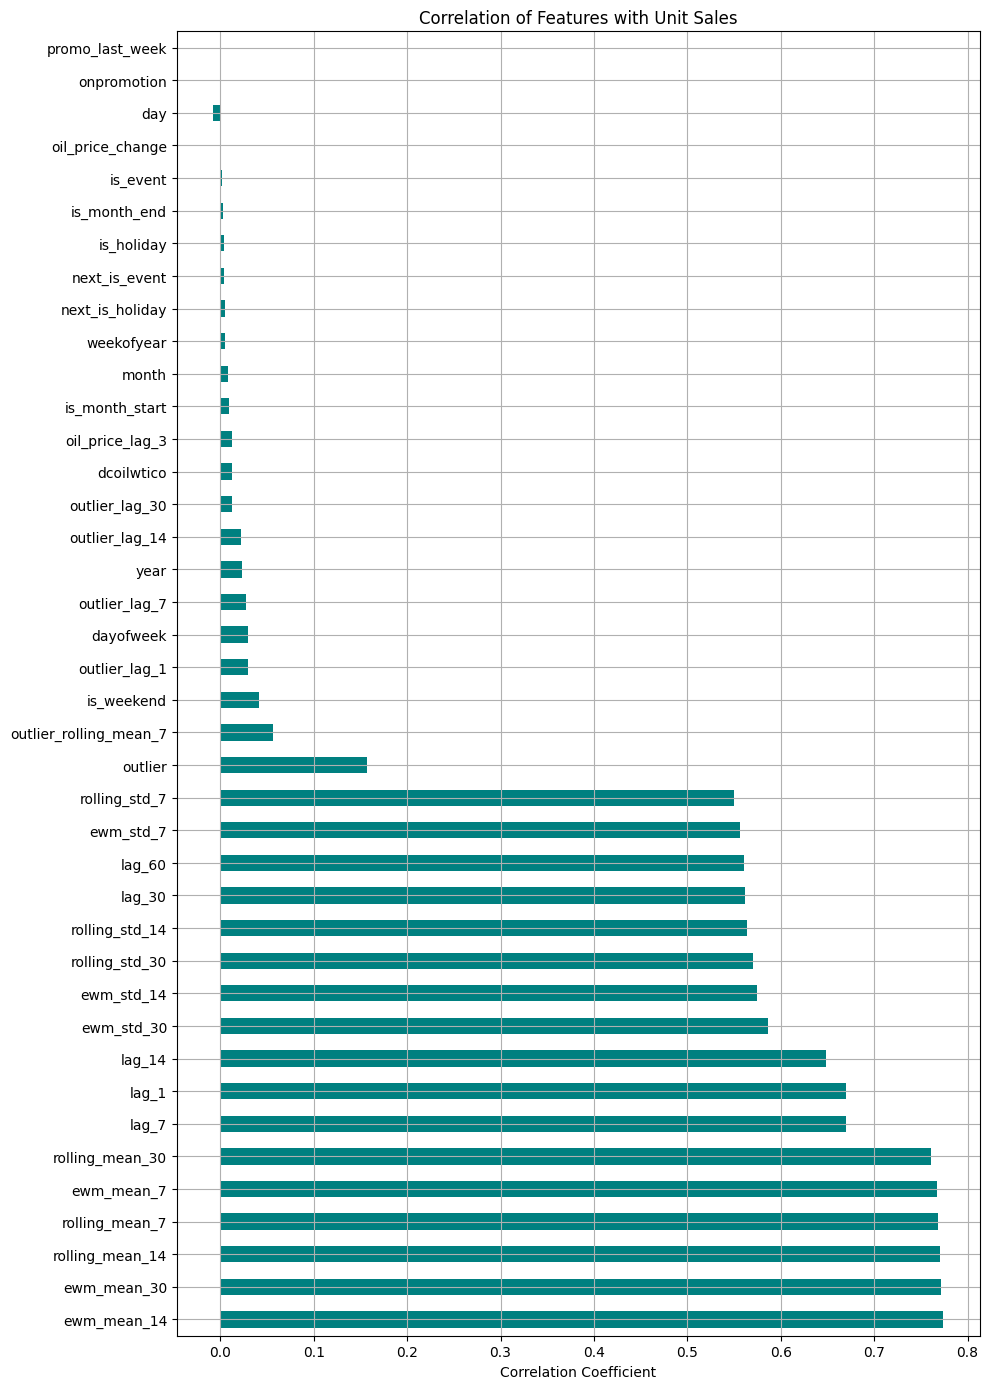

In [8]:
# Exclude specific columns
excluded_columns = ['date', 'store_nbr', 'item_nbr', 'unit_sales']
correlation_columns = [col for col in df_train.columns if col not in excluded_columns]

# Compute correlation
correlation = df_train[correlation_columns + ['unit_sales']].corr()['unit_sales'].drop('unit_sales')

# Plot correlation
plt.figure(figsize=(10, len(correlation) * 0.3 + 2))
correlation.sort_values(ascending=False).plot(kind='barh', color='teal')
plt.title("Correlation of Features with Unit Sales")
plt.xlabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
df_train['unit_sales'].describe()

count    8.190472e+06
mean     2.137629e+00
std      8.473249e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

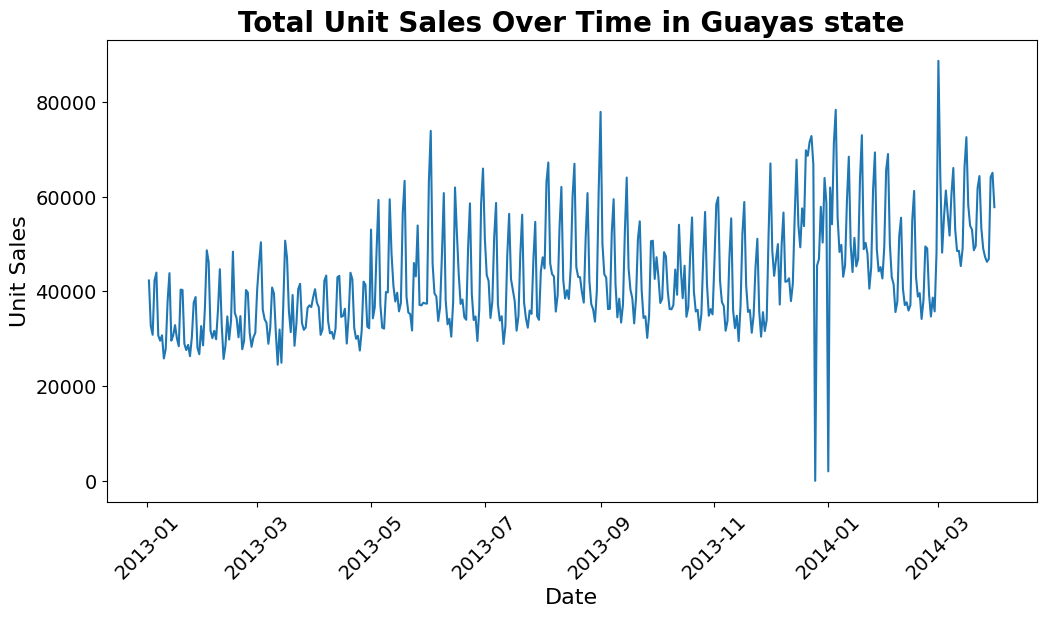

In [9]:
# Aggregating total sales by date
df_train['date'] = pd.to_datetime(df_train['date'])
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [17]:
high_corr_columns

['outlier',
 'lag_1',
 'lag_7',
 'lag_14',
 'lag_30',
 'lag_60',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_30',
 'rolling_std_30',
 'ewm_mean_7',
 'ewm_std_7',
 'ewm_mean_14',
 'ewm_std_14',
 'ewm_mean_30',
 'ewm_std_30']

# **Split in Train/Test**

In [18]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

# Filter columns with more than 10% correlation with 'unit_sales'
high_corr_columns = correlation[correlation.abs() > 0.1].index.tolist()

# Add 'unit_sales' to the list of columns to keep
columns_to_keep = high_corr_columns + ['date', 'store_nbr', 'item_nbr', 'unit_sales']

# Filter train and test datasets
train_filtered = train[columns_to_keep]
test_filtered = test[columns_to_keep]
print(f"Filtered train shape: {train_filtered.shape}")
print(f"Filtered test shape: {test_filtered.shape}")

#train_filtered, test_filtered

# Define target variable (unit_sales) and features
X_train = train_filtered.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test_filtered.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

# Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Filtered train shape: (7566832, 22)
Filtered test shape: (1870920, 22)


# **Baseline Model (XGBoost)**

In [19]:
# Initialize the XGBoost regressor (default parameters)
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, # no of trees
    max_depth=5, # level of each trees
    learning_rate=0.1, # step size shrinkage
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

# **Evaluation of Baseline Model**

In [22]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test_scaled)
# Evaluate the model

print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))

R2: 0.683895512911505
MAE: 1.453832372651734
MSE: 23.822783637378357
RMSE: 4.880858903653983
MAPE: 1335504742663598.2


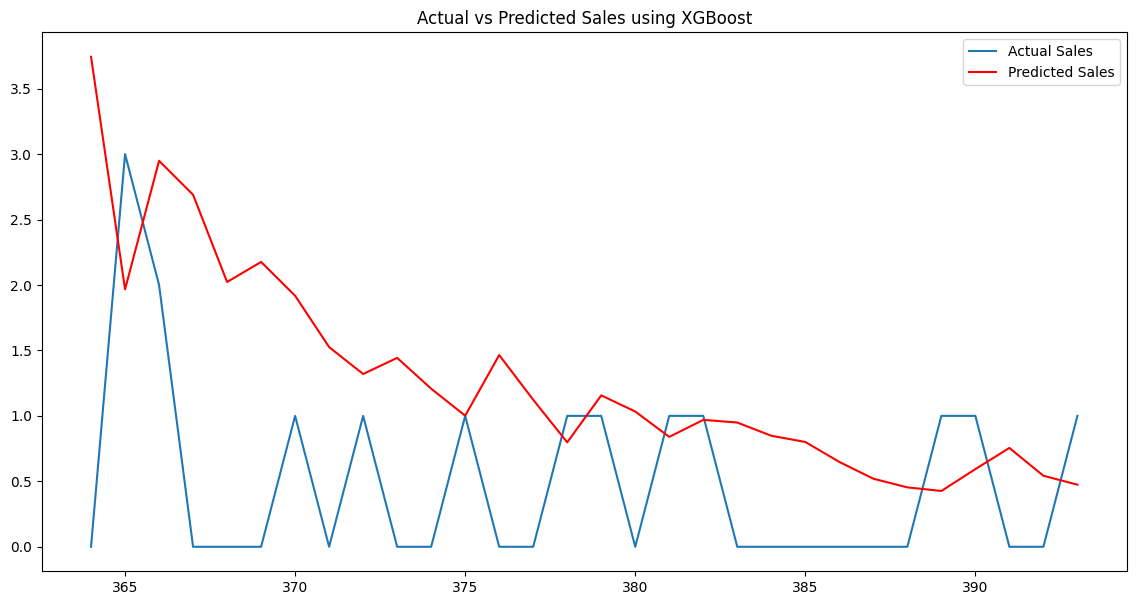

In [23]:
i =30# number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# **Hyperparameter Tuning**

In [24]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train_scaled, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


In [25]:
best_model = random_search.best_estimator_

# **Evaluation with best parameter**

In [27]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
# Evaluate the model

print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))

R2: 0.6865824071757698
MAE: 1.4525981571702407
MSE: 23.62028951493277
RMSE: 4.86007093723258
MAPE: 1355278183567502.2


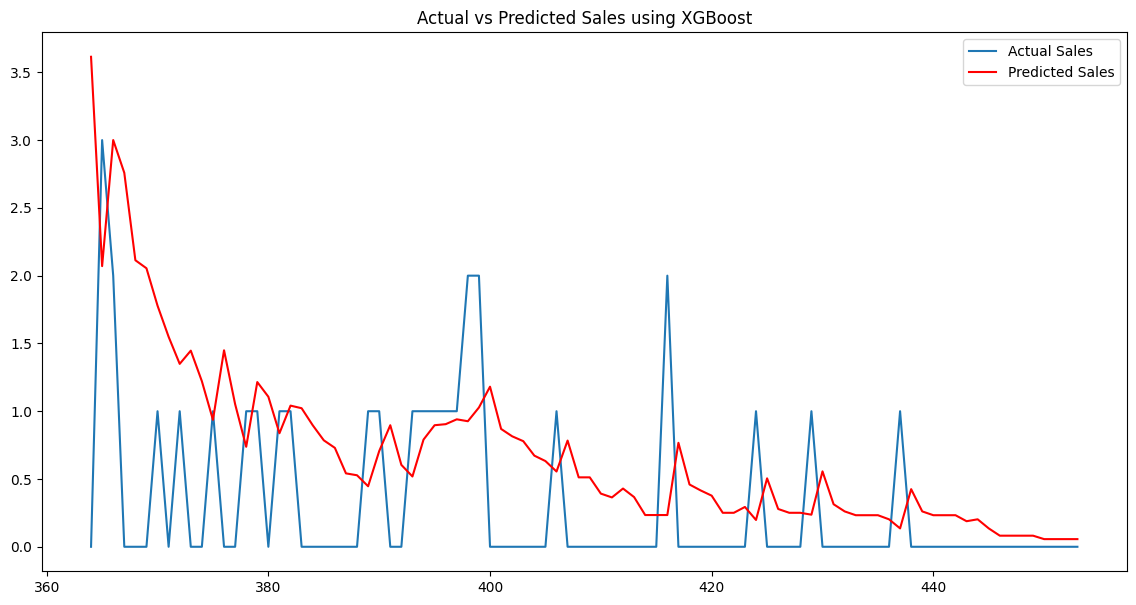

In [29]:
i =90 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()